In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn import metrics

In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'évaluation (données non utilisées en entrainement/test)

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)

##### Chargement du modèle ayant obtenus les meilleurs résultats

In [4]:
from keras.models import load_model
model = load_model('vgg16_fine_tunning_SGD')

#### Prédiction sur les données d'évaluation

In [5]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [6]:
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,218,0,0,3,0,1,0,0
eosinophil,2,621,1,2,0,0,1,0
erythroblast,0,0,302,6,2,0,1,0
ig,0,0,2,575,0,1,12,0
lymphocyte,0,0,4,4,226,2,0,0
monocyte,0,1,0,13,2,285,1,0
neutrophil,0,0,1,19,0,0,662,0
platelet,0,0,0,0,0,0,0,449


> Des cellules sont classées par erreur en IG 
>
> Sinon les cellules sont bien classées

In [7]:
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.99      0.98      0.99       222
  eosinophil       1.00      0.99      0.99       627
erythroblast       0.97      0.97      0.97       311
          ig       0.92      0.97      0.95       590
  lymphocyte       0.98      0.96      0.97       236
    monocyte       0.99      0.94      0.96       302
  neutrophil       0.98      0.97      0.97       682
    platelet       1.00      1.00      1.00       449

    accuracy                           0.98      3419
   macro avg       0.98      0.97      0.98      3419
weighted avg       0.98      0.98      0.98      3419



> Très bon score de 98.3%, confirmation de la précision moindre sur les IG

In [8]:
# Etude des pourcentages obtenus dans la classe à prédire
pourcent = [(predict[np.where(np.array(eval_generator.classes) == i),i]*100).reshape(-1) for i in range(8)]

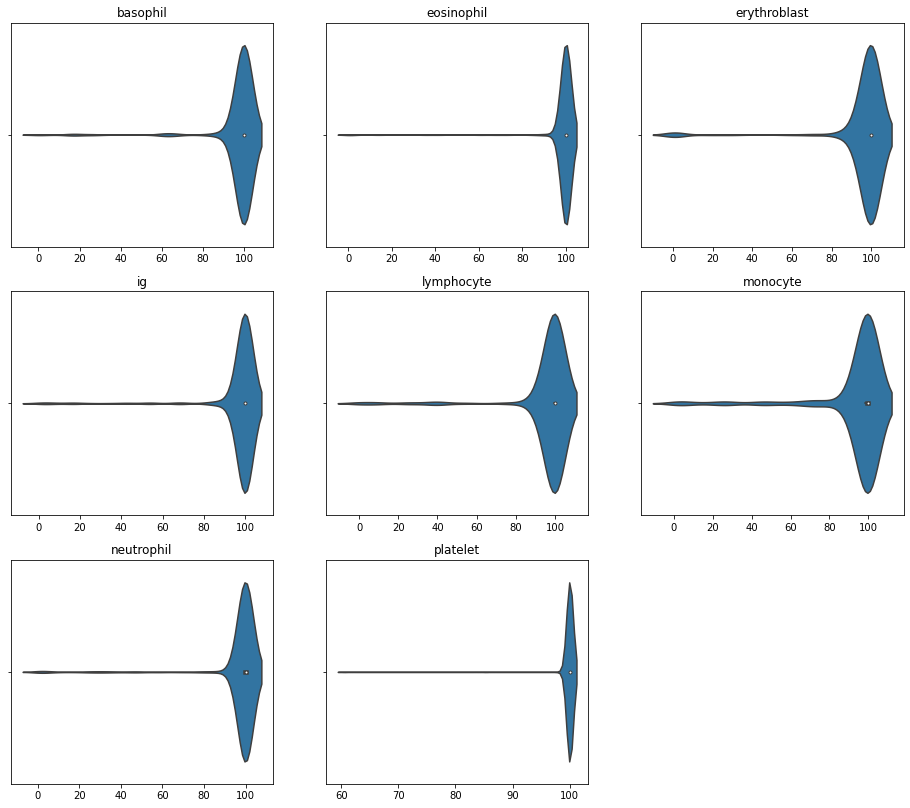

In [9]:
fig = plt.figure(figsize=(16,14))
for i in range(8):
        ax = fig.add_subplot(3, 3, i + 1)
        plt.title(lst_classes[i])
        sns.violinplot(x=pourcent[i],ax=ax)

> Les prédictions sont faites avec des pourcentages supérieures à 85%

## Etude sur un autre jeu de données

In [11]:
# Cellules issues de la base leucémique
df = pd.read_csv('../base_apl_aml.csv',index_col=0)
df.head()

,Patient_ID,file_path,filename,class,size
0,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,BL_15336348.jpg,blast,"(363, 360, 3)"
1,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,BL_15336349.jpg,blast,"(363, 360, 3)"
2,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,BL_15336361.jpg,blast,"(363, 360, 3)"
3,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,BL_15336369.jpg,blast,"(363, 360, 3)"
4,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,BL_15336376.jpg,blast,"(363, 360, 3)"


In [12]:
# Récupère uniquement les 8 types de cellules
df = df[(df['class'] == 'neutrophil' )
      | (df['class'] == 'lymphocyte' )
      | (df['class'] == 'ig')
       | (df['class'] == 'monocyte')
       | (df['class'] == 'eosinophil')
       | (df['class'] == 'platelet')
       | (df['class'] == 'erythroblast')
       | (df['class'] == 'basophil')
       ]

In [14]:
df['class'].value_counts()

lymphocyte      3405
neutrophil      2071
monocyte        1299
ig               920
erythroblast     517
eosinophil       108
platelet          66
basophil          53
Name: class, dtype: int64

In [15]:
#On réduit à 500 images max par type
data_eval = pd.concat( [df[ (df['class'] == 'eosinophil')  | (df['class'] == 'platelet')| (df['class'] == 'basophil')],
                          df[(df['class'] == 'neutrophil')].iloc[:500,:],
                          df[(df['class'] == 'lymphocyte')].iloc[:500,:],
                          df[(df['class'] == 'ig')].iloc[:500,:],
                          df[(df['class'] == 'monocyte')].iloc[:500,:],
                          df[(df['class'] == 'erythroblast')].iloc[:500,:]
                          ])
       
data_eval['class'].value_counts()

neutrophil      500
lymphocyte      500
ig              500
monocyte        500
erythroblast    500
eosinophil      108
platelet         66
basophil         53
Name: class, dtype: int64

In [18]:
data_eval.head()

,Patient_ID,file_path,filename,class,size
6,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,EO_15336344.jpg,eosinophil,"(363, 360, 3)"
7,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,EO_15336371.jpg,eosinophil,"(363, 360, 3)"
11,Patient_00,../images_apl_aml/All/All/Patient_00/Signed sl...,GT_15336368.jpg,platelet,"(363, 360, 3)"
193,Patient_02,../images_apl_aml/All/All/Patient_02/Signed sl...,BA_5899689.jpg,basophil,"(363, 360, 3)"
204,Patient_02,../images_apl_aml/All/All/Patient_02/Signed sl...,GT_5899553.jpg,platelet,"(363, 360, 3)"


#### Prédictions sur les images issues de la base leucémique sans entrainement dessus

In [21]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
eval_generator = data_generator.flow_from_dataframe(data_eval, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)

Found 2727 validated image filenames belonging to 8 classes.


In [22]:
#Classes prédites
predict = model.predict(eval_generator)
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       1.00      0.17      0.29        53
  eosinophil       0.92      0.20      0.33       108
erythroblast       0.52      0.96      0.67       500
          ig       0.27      0.34      0.30       500
  lymphocyte       0.28      0.22      0.25       500
    monocyte       0.59      0.16      0.25       500
  neutrophil       0.87      0.62      0.72       500
    platelet       0.15      0.62      0.24        66

    accuracy                           0.45      2727
   macro avg       0.58      0.41      0.38      2727
weighted avg       0.52      0.45      0.43      2727



> Les rappels sont vraiment faibles sur les basophils, eosinophil, ig, lymphocyte, monocyte
>
> La précision est faible sur les IG, monocyte et plus étonnant les platelets

In [23]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,9,0,8,17,8,1,1,9
eosinophil,0,22,26,19,5,3,17,16
erythroblast,0,0,480,2,5,0,2,11
ig,0,0,11,168,178,46,6,91
lymphocyte,0,0,267,86,111,1,0,35
monocyte,0,0,3,268,84,79,19,47
neutrophil,0,2,115,52,2,2,308,19
platelet,0,0,21,0,1,2,1,41


> Problème de confusion avec IG/Monocyte et IG/Lymphocyte
>
> Nombreuses cellules prédites à tort en IG, erythroblast et lymphocyte

### Conclusion

> Très bon score obtenu sur la même base d'image, mais mauvais score sur une autre base semblant cependant très similaire
>
> Le modèle identifie des caractéristiques qui ne se retrouve pas sur la nouvelle base, ne semble donc pas identifier les bons caractéristiques
